In [2]:
import pandas as pd

In [3]:
# !pip install matplotlib

In [4]:
def get_df(csv):
    df = pd.read_csv(csv)
    return df

def display_df(df):
    return df["cores_used	cpu_load	temperature	cpu_freq	rapl_power	estimated_power	tapo_power	tapo_energy".split("\t")]

def plot(df, with_tapo=False):
    # Plot the power in Y and the CPU load in X
    if with_tapo:
        return df.plot(x='cpu_load', y=['tapo_power', 'rapl_power', 'estimated_power'], kind='line', title='CPU Load vs Power Consumption')
    else:
        return df.plot(x='cpu_load', y=['rapl_power', 'estimated_power'], kind='line', title='CPU Load vs Power Consumption')

# AMD EPYC

In [5]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_EPYC_8024P_8C/compare_cpu_load_and_RAPL-all_cores-AMD_EPYC_8024P_8-Core_Processor-2025-01-10.csv'
df_all_cores = get_df(csv)
display_df(df_all_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,16,0.0,0,1581.218063,0.453753,0.453731,0,0
1,16,11.8,0,1541.909437,14.292327,14.291673,0,0
2,16,21.7,0,1498.603188,34.770111,34.769669,0,0
3,16,29.6,0,1498.392750,37.366123,37.365986,0,0
4,16,40.3,0,1466.167250,38.338461,38.338956,0,0
5,16,49.7,0,2995.399937,41.238883,41.240369,0,0
6,16,60.0,0,2995.390125,49.722814,49.722250,0,0
7,16,69.8,0,2995.423688,50.300625,50.302515,0,0
8,16,80.7,0,2995.666062,52.226447,52.225818,0,0
9,16,90.7,0,2995.390937,53.337064,53.336338,0,0


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

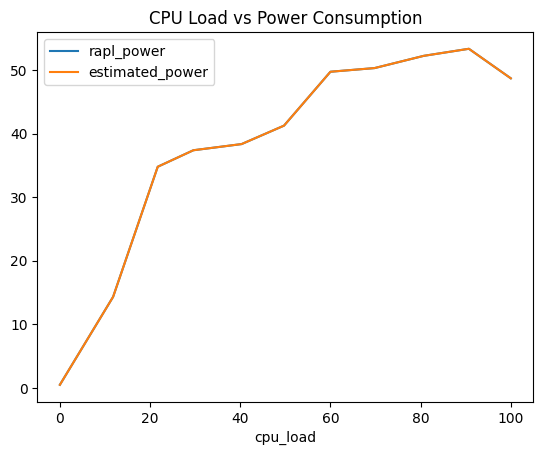

In [6]:
plot(df_all_cores)

In [7]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_EPYC_8024P_8C/compare_cpu_load_and_RAPL-some_cores-AMD_EPYC_8024P_8-Core_Processor-2025-01-10.csv'
df_some_cores = get_df(csv)
display_df(df_some_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,0,0.0,0,1544.372437,47.645292,47.645914,0,0
1,1,6.2,0,1767.649500,14.940831,14.940072,0,0
2,3,18.7,0,1902.968375,38.342044,38.342546,0,0
3,4,25.0,0,1911.662750,42.416944,42.417484,0,0
4,6,37.3,0,2248.637938,44.529367,44.530468,0,0
5,8,50.3,0,2609.188750,48.494484,48.496316,0,0
6,9,56.2,0,2528.005437,50.695776,50.695659,0,0
7,11,68.9,0,2701.283188,51.384413,51.385244,0,0
8,12,75.5,0,2808.454750,52.366344,52.367155,0,0
9,14,87.5,0,2901.938750,47.328832,47.329393,0,0


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

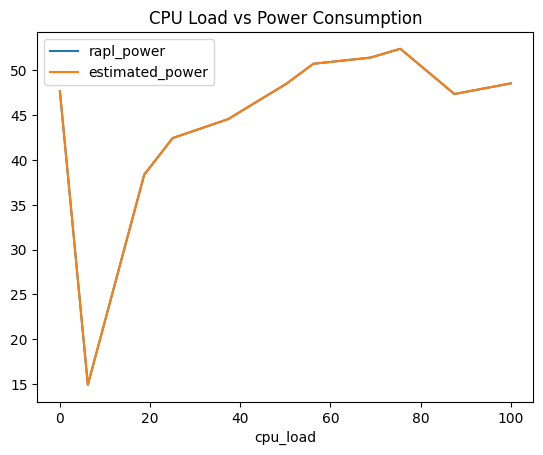

In [8]:
plot(df_some_cores)

## AMD Ryzen Threadripper

In [9]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_Threadripper/compare_cpu_load_and_RAPL-all_cores-AMD_Ryzen_Threadripper_1950X_16-Core_Processor-2025-01-10.csv'
df_all_cores = get_df(csv)
display_df(df_all_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,32,5.9,29.0,2174.306375,1.330197,3.472258,0,0
1,32,42.6,43.0,2324.945625,43.134062,125.046699,0,0
2,32,82.2,53.0,3682.327156,102.197222,169.818726,0,0
3,32,100.0,55.0,3250.705375,165.908602,171.951567,0,0
4,32,100.0,57.0,3564.883781,165.312236,171.952226,0,0
5,32,100.0,57.0,3641.797781,165.402647,171.951858,0,0
6,32,100.0,58.0,3601.685406,165.384352,171.940670,0,0
7,32,100.0,58.0,3625.480969,165.333360,172.063837,0,0
8,32,100.0,58.0,3664.252000,165.319252,172.157659,0,0
9,32,100.0,58.0,3356.095781,165.534267,172.220301,0,0


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

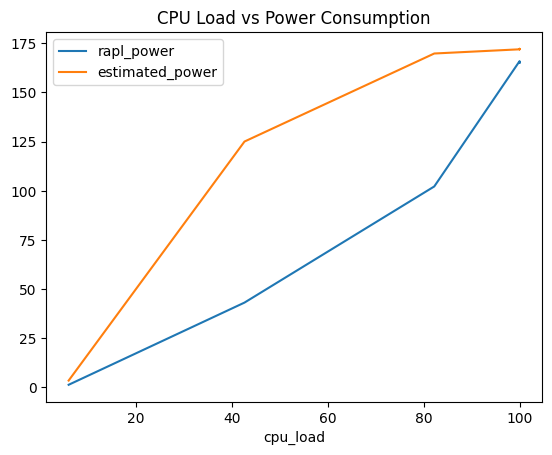

In [10]:
plot(df_all_cores)

In [11]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/AMD_Threadripper/compare_cpu_load_and_RAPL-some_cores-AMD_Ryzen_Threadripper_1950X_16-Core_Processor-2025-01-10.csv'
df_some_cores = get_df(csv)
display_df(df_some_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,0,2.8,46.0,2416.416031,161.470860,3.118065,0,0
1,3,20.3,52.0,2495.237938,43.851914,15.430065,0,0
2,6,22.8,55.0,2554.300219,74.278257,42.195484,0,0
3,9,32.8,51.0,2829.060812,89.973009,71.387881,0,0
4,12,40.3,56.0,2926.177187,116.674215,100.808967,0,0
5,16,55.8,58.0,3179.436438,144.049612,149.931510,0,0
6,19,66.8,60.0,3454.412656,174.876364,159.420130,0,0
7,22,70.8,60.0,3383.331281,173.843325,164.890187,0,0
8,25,80.5,60.0,3476.244844,170.968411,168.563672,0,0
9,28,89.7,58.0,3274.504406,167.990272,170.564724,0,0


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

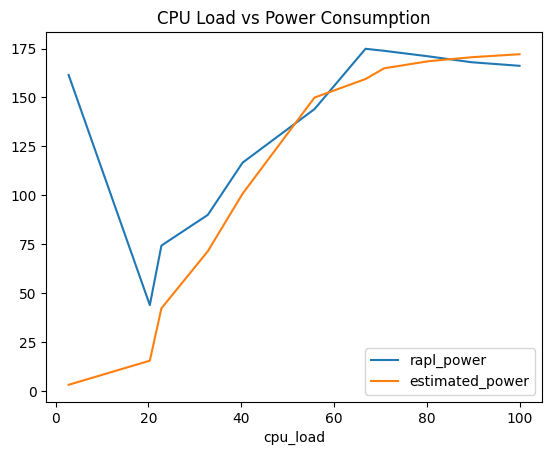

In [12]:
plot(df_some_cores)

## Intel Xeon E5-2620 v3

In [13]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E5-2620/compare_cpu_load_and_RAPL-all_cores-Intel(R)_Xeon(R)_CPU_E5-2620_v3_@_2.40GHz-2025-01-11.csv'
df_all_cores = get_df(csv)
display_df(df_all_cores)

,cores_used,cpu_load,temperature,cpu_freq,rapl_power,estimated_power,tapo_power,tapo_energy
0,24,0.0,33.642857,1250.039792,0.497070,0.010968,0,0
1,24,10.8,34.571429,1200.025417,15.916166,8.206613,0,0
2,24,19.8,35.714286,1200.003458,31.280466,16.520161,0,0
3,24,31.8,36.357143,1218.434208,36.027754,24.756935,0,0
4,24,39.2,37.357143,1257.057500,39.552478,33.051290,0,0
5,24,52.7,39.428571,1775.084167,45.043987,41.225000,0,0
6,24,59.8,42.000000,2248.756042,58.263839,49.472742,0,0
7,24,70.4,46.428571,2630.997250,74.551271,57.693065,0,0
8,24,79.9,49.214286,2603.179083,106.341953,65.896935,0,0
9,24,90.4,51.214286,2600.076167,110.782964,74.150161,0,0


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

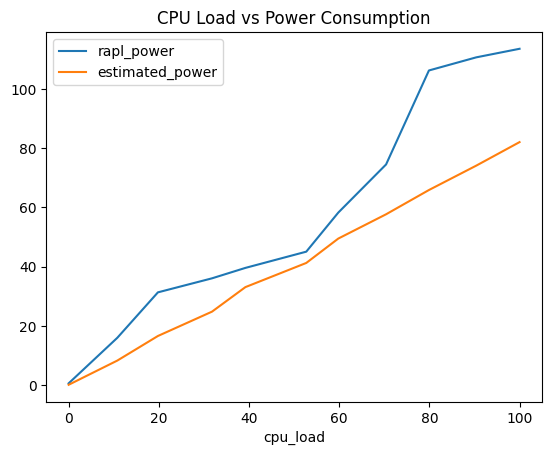

In [14]:
plot(df_all_cores)

<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

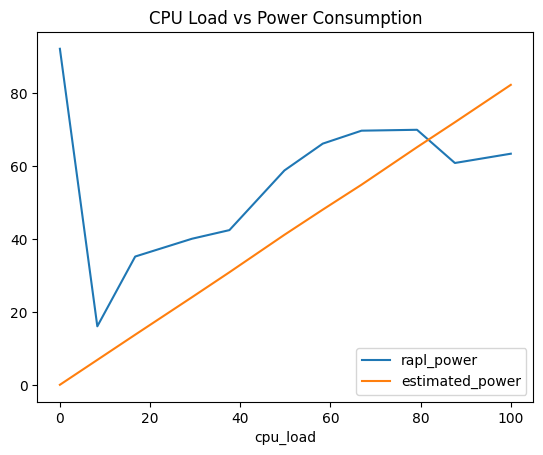

In [15]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E5-2620/compare_cpu_load_and_RAPL-some_cores-Intel(R)_Xeon(R)_CPU_E5-2620_v3_@_2.40GHz-2025-01-11.csv'
df_some_cores = get_df(csv)
plot(df_some_cores)

## Intel(R) Xeon(R) CPU E3-1240 V2 @ 3.40GHz

In [16]:
!ls ../codecarbon/data/hardware/cpu_load_profiling/E3-1240/

'compare_cpu_load_and_RAPL-all_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-11.csv'
'compare_cpu_load_and_RAPL-all_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-11-tasks.csv'
'compare_cpu_load_and_RAPL-some_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-11.csv'
'compare_cpu_load_and_RAPL-some_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-11-tasks.csv'


In [19]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E3-1240/compare_cpu_load_and_RAPL-all_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-11.csv'
df_all_cores = get_df(csv)
# display_df(df_all_cores)

<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

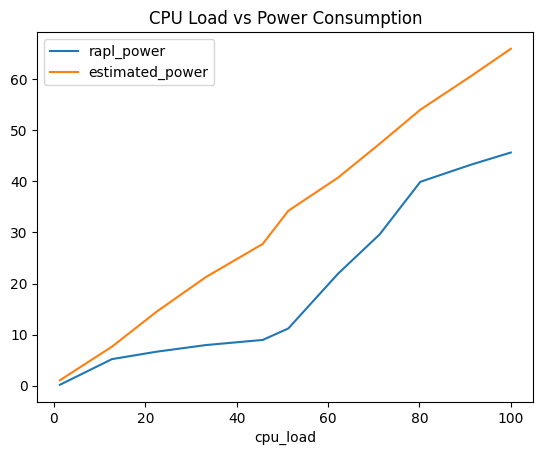

In [18]:
plot(df_all_cores)


<Axes: title={'center': 'CPU Load vs Power Consumption'}, xlabel='cpu_load'>

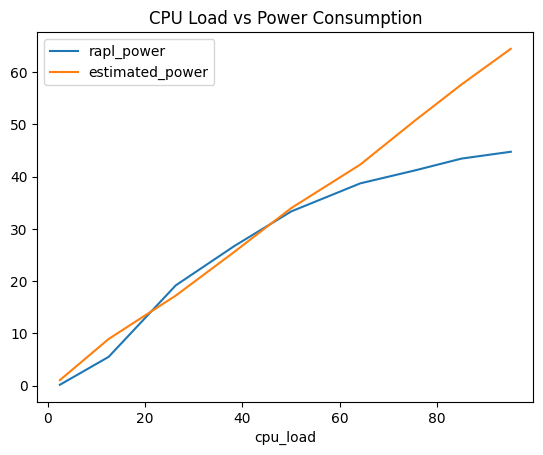

In [20]:
csv = '../codecarbon/data/hardware/cpu_load_profiling/E3-1240/compare_cpu_load_and_RAPL-some_cores-Intel(R)_Xeon(R)_CPU_E3-1240_V2_@_3.40GHz-2025-01-11.csv'
df_some_cores = get_df(csv)
plot(df_some_cores)